## Question 8

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
     (Stepwise,
      sklearn_selected,
      sklearn_selection_path)
from l0bnb import fit_path
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(0)

In [3]:
n = 100

In [4]:
X = np.random.normal(size = n)
eps = np.random.normal(size = n)

In [5]:
Y = 1 + 2*X + 3*X**2 + 4*X**3 + eps

In [6]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n 

In [7]:
X_powers = pd.DataFrame({f'X^{i}': X**i for i in range(1, 11)})

In [8]:
design = MS(X_powers.columns).fit(X_powers)
X_1 = design.transform(X_powers)
sigma2 = OLS(Y,X_1).fit().scale

In [9]:
neg_Cp = partial(nCp, sigma2)

In [10]:
strategy = Stepwise.first_peak(design, 
                               direction='foward', 
                               max_terms=len(design.terms))

In [11]:
X_Cp = sklearn_selected(OLS, 
                        strategy,
                        scoring=neg_Cp)
X_Cp.fit(X_powers, Y)
X_Cp.selected_state_

('X^1', 'X^2', 'X^3', 'X^5')

In [12]:
design = MS(['X^1','X^2', 'X^3', 'X^5']).fit(X_powers)
X_1 = design.transform(X_powers)
results = OLS(Y,X_1).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     5557.
Date:                Tue, 06 Feb 2024   Prob (F-statistic):          1.15e-111
Time:                        20:31:18   Log-Likelihood:                -142.54
No. Observations:                 100   AIC:                             295.1
Df Residuals:                      95   BIC:                             308.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1772      0.133      8.881      0.000       0.914       1.440
X^1            1.7307      0.303      5.706      0.000       1.129       2.333
X^2            2.8843      0.084     34.287      0.000       2.717       3.051
X^3            4.3775      0.222     19.755      0.000       3.938       4.817
X^5           -0.0611      0.033     -1.841      0.069      -0.127       0.005
==============================================================================
Omnibus:                       10.184   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                3.985
Skew:                           0.175   Prob(JB):                        0.136
Kurtosis:                       2.087   Cond. No.                         55.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
D = MS(X_powers.columns).fit_transform(X_powers)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [14]:
scaler = StandardScaler(with_mean=True,  with_std=True)

lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=5)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X_powers, Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.01485566681876669

In [15]:
lambdas, soln_array = skl.Lasso.path(X_powers, 
                                    Y,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

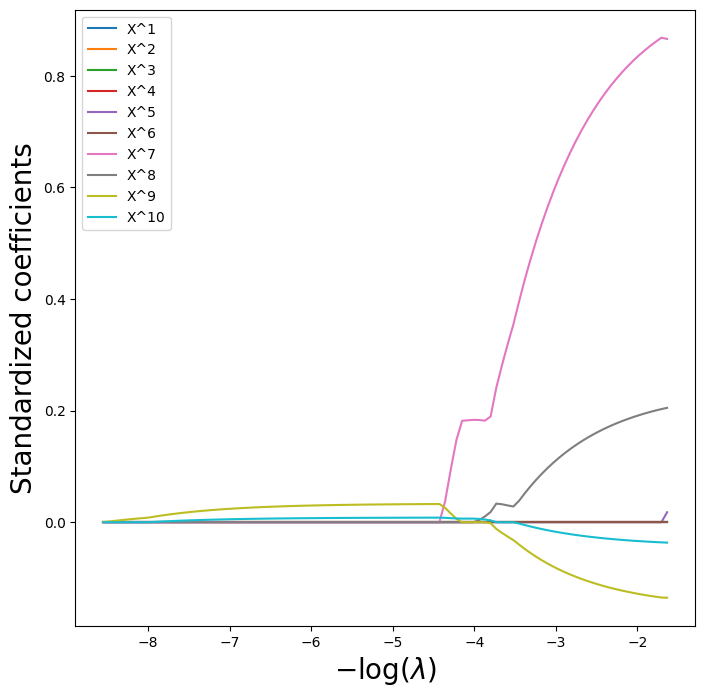

In [16]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20);

In [17]:
np.min(tuned_lasso.mse_path_.mean(1))

1.171043033950114

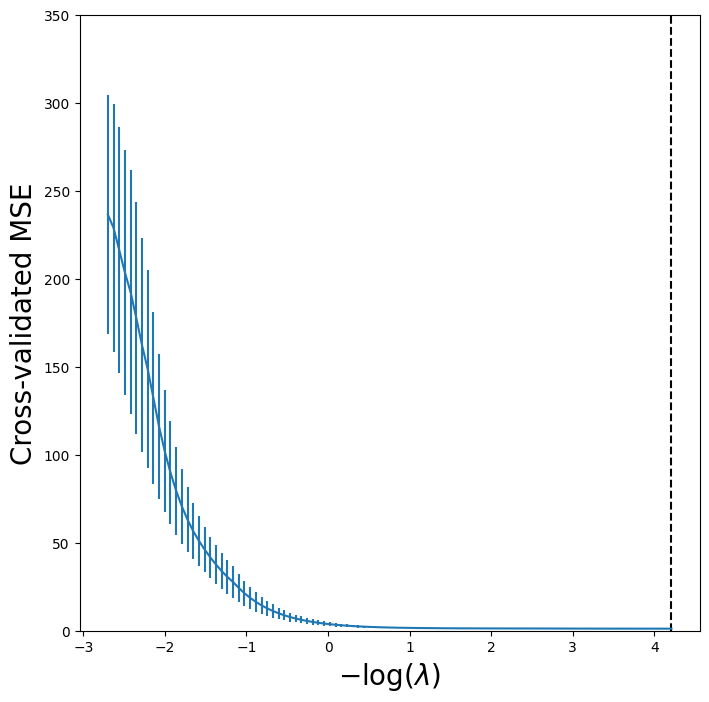

In [18]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([0, 350])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [19]:
tuned_lasso.coef_

array([ 2.0404252 ,  3.53897993, 12.96241303,  0.25131102, -0.        ,
        0.        , -0.10562346,  0.        , -0.0538762 , -0.        ])

## Question 9

In [20]:
college = load_data('College')
college = pd.get_dummies(college, columns = ['Private'])
college.shape

(777, 19)

In [21]:
college_train, college_test = train_test_split(college, test_size=388, random_state=0)

In [22]:
m_train = MS(college.columns.drop(['Apps']))
X_train = m_train.fit_transform(college_train)
y_train = college_train['Apps']
model = OLS(y_train, X_train)
results = model.fit()

In [23]:
X_test = m_train.transform(college_test)
y_test = college_test['Apps']
test_pred = results.predict(X_test)
np.mean((y_test - test_pred)**2)

1261943.5072813816

In [24]:
D = m_train.fit_transform(college_train)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [25]:
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None,:]
lambdas = 10**np.linspace(8, -2, 100) / y_train.std()
soln_array = skl.ElasticNet.path(Xs,
                                 y_train,
                                 l1_ratio=0.,
                                 alphas=lambdas)[1]
soln_array.shape

C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4895342748.089406, tolerance: 979158.2105
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: 

(18, 100)

In [26]:
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate,Private_No,Private_Yes
negative log(lambda),,,,,,,,,,,,,,,,,,
-10.153649,0.141997,0.132839,0.060411,0.061770,0.128390,0.062896,0.011305,0.029047,0.021707,0.027799,0.066848,0.063473,0.014418,-0.010415,0.046765,0.021598,0.071849,-0.071849
-9.921064,0.179172,0.167617,0.076226,0.077941,0.162002,0.079361,0.014265,0.036652,0.027389,0.035076,0.084348,0.080089,0.018192,-0.013141,0.059009,0.027253,0.090658,-0.090658
-9.688480,0.226077,0.211496,0.096181,0.098344,0.204412,0.100135,0.018000,0.046248,0.034559,0.044257,0.106426,0.101052,0.022954,-0.016582,0.074456,0.034388,0.114389,-0.114389
-9.455896,0.285258,0.266858,0.121356,0.124085,0.257919,0.126344,0.022712,0.058354,0.043604,0.055840,0.134281,0.127500,0.028962,-0.020923,0.093946,0.043390,0.144329,-0.144329
-9.223311,0.359924,0.336706,0.153119,0.156560,0.325427,0.159410,0.028658,0.073629,0.055016,0.070452,0.169421,0.160865,0.036542,-0.026401,0.118535,0.054748,0.182102,-0.182102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11.941865,3154.386523,-285.162481,1037.094264,-419.319603,495.661852,47.595657,-137.021602,206.016955,-7.180445,-39.962738,-175.505055,-58.447067,67.624242,-93.003968,386.408524,204.407044,145.852757,-146.105905
12.174449,3154.433218,-285.216794,1037.114502,-419.335337,495.672743,47.597176,-137.030674,206.013952,-7.180527,-39.961746,-175.509179,-58.442908,67.624601,-92.998903,386.406661,204.406439,145.851121,-146.104591
12.407033,3154.470225,-285.259839,1037.130541,-419.347805,495.681376,47.598379,-137.037864,206.011572,-7.180591,-39.960961,-175.512448,-58.439612,67.624886,-92.994889,386.405185,204.405960,145.849823,-146.103549


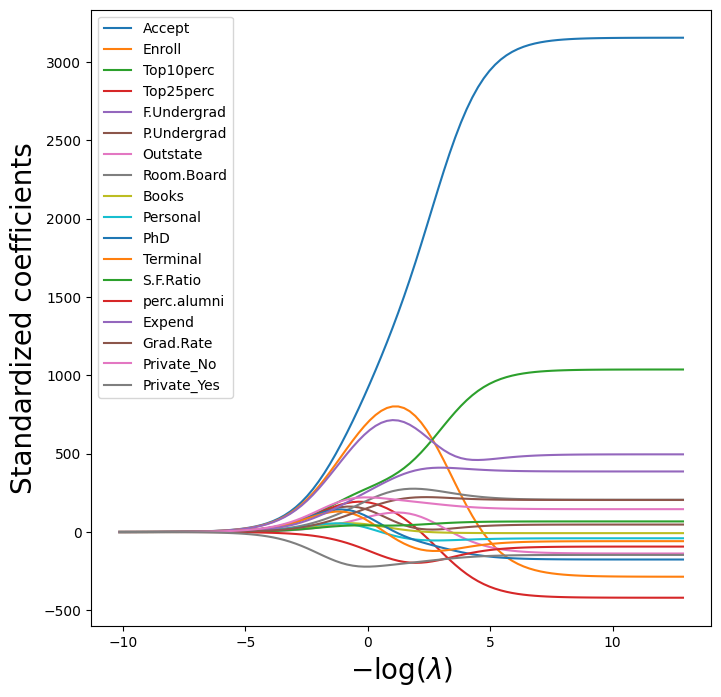

In [27]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)
ax.legend(loc='upper left');

In [28]:
outer_valid = skm.ShuffleSplit(n_splits=1, 
                               test_size=0.25,
                               random_state=1)
inner_cv = skm.KFold(n_splits=5,
                     shuffle=True,
                     random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas,
                           l1_ratio=0,
                           cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)]);

In [29]:
results = skm.cross_validate(pipeCV, 
                             X_train,
                             y_train,
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1870498034.206327, tolerance: 374159.914275431
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:

array([1028479.05433353])

In [30]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0,
                           cv=5)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('ridge', ridgeCV)])
pipeCV.fit(X_train, y_train)

C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2186028786.1495166, tolerance: 437269.7360237943
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:614: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\linear_model\_coordinate_descent.p

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge',
                 ElasticNetCV(alphas=array([2.56846494e+04, 2.03546454e+04, 1.61307084e+04, 1.27833105e+04,
       1.01305550e+04, 8.02829158e+03, 6.36228378e+03, 5.04200109e+03,
       3.99569964e+03, 3.16652363e+03, 2.50941582e+03, 1.98866913e+03,
       1.57598627e+03, 1.24894217e+03, 9.89765310e+02, 7.84372082e+02,
       6.21601461e+02, 4.92608527e+02,...
       5.40637250e-04, 4.28445775e-04, 3.39535950e-04, 2.69076433e-04,
       2.13238472e-04, 1.68987842e-04, 1.33919975e-04, 1.06129290e-04,
       8.41056473e-05, 6.66522871e-05, 5.28207977e-05, 4.18595788e-05,
       3.31730004e-05, 2.62890355e-05, 2.08336110e-05, 1.65102805e-05,
       1.30841149e-05, 1.03689373e-05, 8.21720549e-06, 6.51199482e-06,
       5.16064453e-06, 4.08972253e-06, 3.24103517e-06, 2.56846494e-06]),
                              cv=5, l1_ratio=0))])

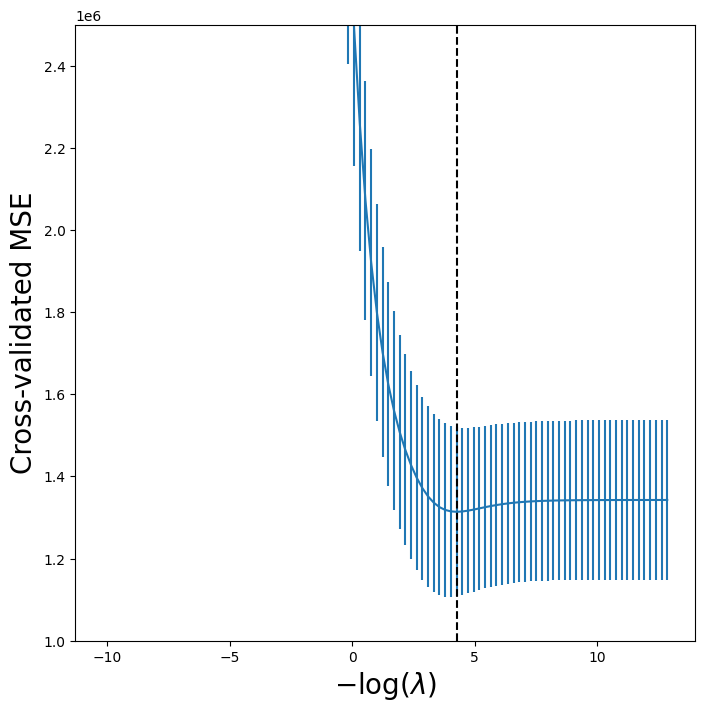

In [31]:
tuned_ridge = pipeCV.named_steps['ridge']
ridgeCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas),
            tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_ylim([1000000,2500000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [32]:
np.min(tuned_ridge.mse_path_.mean(1))

1313919.4607272942

In [33]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=5)
pipeCV = Pipeline(steps=[('scaler', scaler),
                         ('lasso', lassoCV)])
pipeCV.fit(X, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

11.944646210837268

In [34]:
lambdas, soln_array = skl.Lasso.path(X, 
                                    y_train,
                                    l1_ratio=1,
                                    n_alphas=100)[:2]
soln_path = pd.DataFrame(soln_array.T,
                         columns=D.columns,
                         index=-np.log(lambdas))

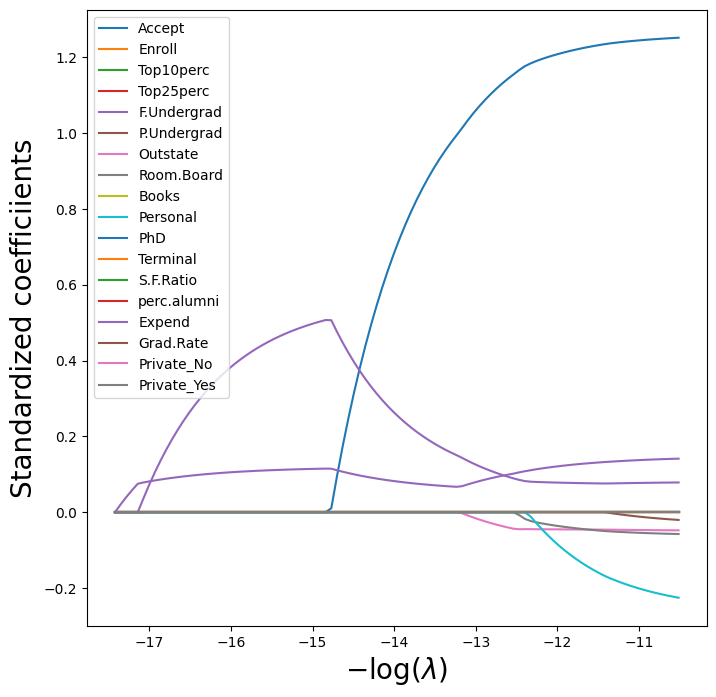

In [35]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficiients', fontsize=20);

In [36]:
np.min(tuned_lasso.mse_path_.mean(1))

1319283.083529449

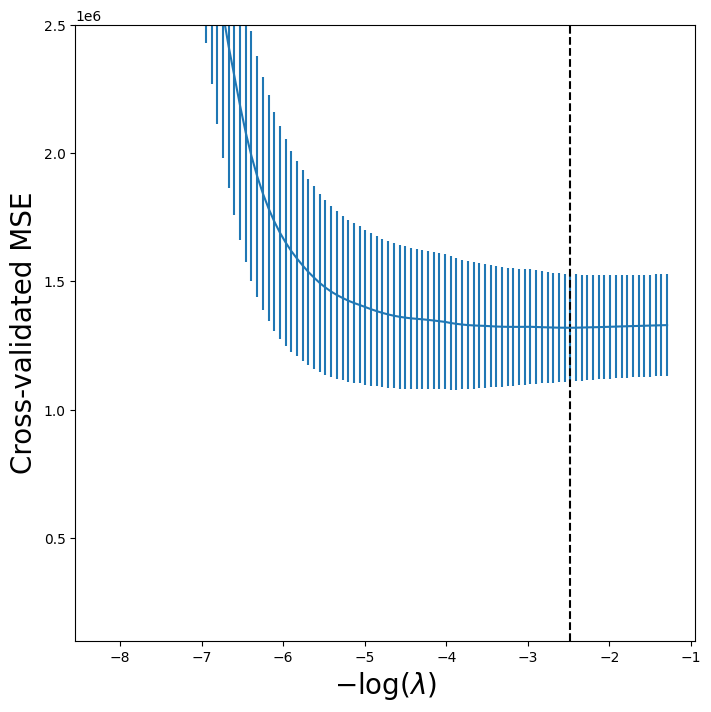

In [38]:
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(5))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([100000,2500000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20);

In [39]:
tuned_lasso.coef_

array([ 3.04569098e+03,  0.00000000e+00,  8.77661635e+02, -2.79169721e+02,
        3.12823154e+02,  3.04784929e+01, -7.55579623e+01,  1.87155450e+02,
       -0.00000000e+00, -2.17762490e+01, -1.32479142e+02, -6.69651572e+01,
        4.11261083e+01, -9.23164621e+01,  3.54058202e+02,  1.64858528e+02,
        2.85588836e+02, -1.58518614e-12])

In [43]:
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('scaler', scaler), 
                 ('pca', pca),
                 ('linreg', linreg)])
pipe.fit(X, y_train)
pipe.named_steps['linreg'].coef_

array([ -31.18135907, 1513.34175039])

In [45]:
param_grid = {'pca__n_components': range(1, 20)}
grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X, y_train)

C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\pipeline.py", line 423, in fit
   

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

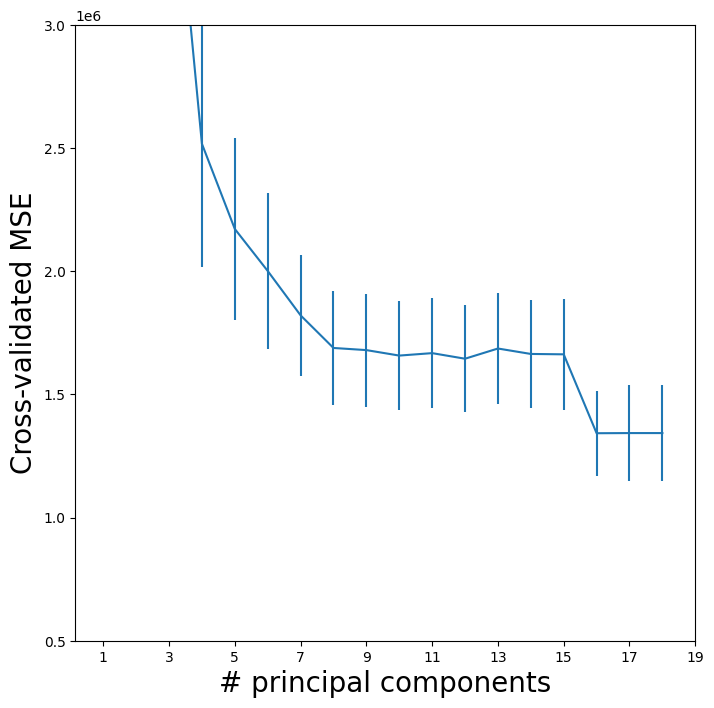

In [50]:
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([500000,3000000]);

In [56]:
pls = PLSRegression(n_components=2, 
                    scale=True)
pls.fit(X, y_train)

PLSRegression()

In [58]:
param_grid = {'n_components':range(1, 20)}
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=5,
                        scoring='neg_mean_squared_error')
grid.fit(X, y_train)

C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 95.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\cross_decomposition\_pls.py", line 643, in fit
    super().fit(X, Y)
  File "C:\Users\jimbo\.conda\envs\islp\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^

GridSearchCV(cv=5, estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

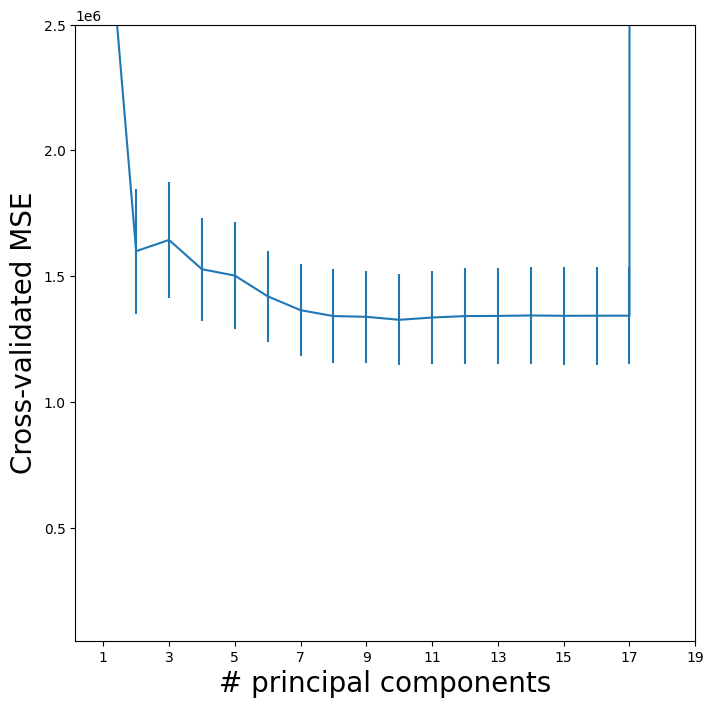

In [61]:
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(5))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,2500000]);
